# **Import Dependencies**

In [48]:
import os, re
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from matplotlib import pyplot  as plt

import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [49]:
class_dict = {0: 'negative', 1: 'positive'}

# **1. Data Analysis & Visualization**


In [50]:
df_cloths = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [51]:
# Class Imabalnce 
class_imbalance = df_cloths.groupby('sentiment').count()
sentiment =  np.array([class_dict[elem] for elem in class_imbalance.index.values])
review_count = np.array([elem.squeeze() for elem in class_imbalance.values])

class_imbalance

,Review Text
sentiment,
0,4101
1,18540


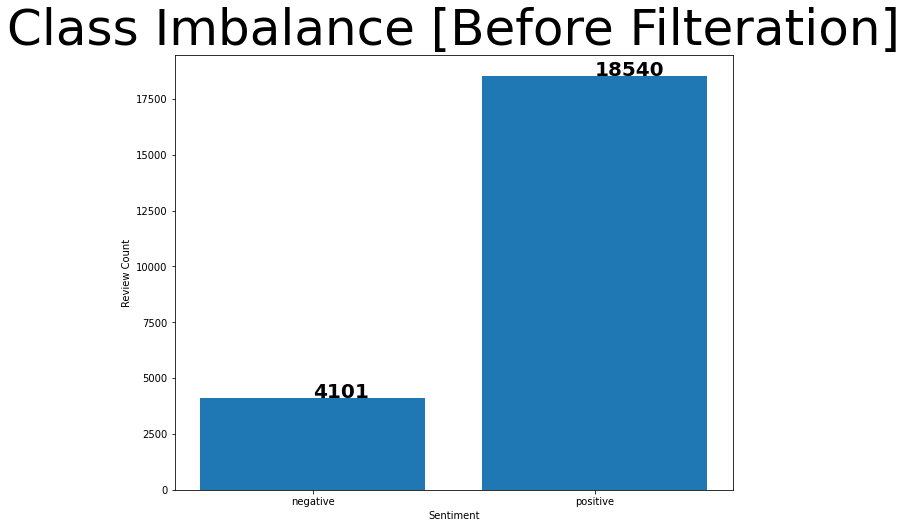

In [52]:
plt.figure(figsize=(10,8))
plt.bar(sentiment, review_count)

plt.title('Class Imbalance [Before Filteration]', fontsize=50)
plt.xlabel('Sentiment')
plt.ylabel('Review Count')

for i, v in enumerate(review_count):
    plt.text(i, v, str(v), color='black', fontweight='bold', fontsize=20)

plt.show()

In [53]:
# handle Null values

df_cloths.isnull().sum()

Review Text    845
sentiment        0
dtype: int64

In [54]:
df_cloths = df_cloths.dropna()
df_cloths.isnull().sum()

Review Text    0
sentiment      0
dtype: int64

In [55]:
# Handle Class Imbalance
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

sentiment = df_cloths['sentiment'].values
class_weights = compute_class_weight('balanced',
                                    classes=np.unique(sentiment),
                                    y=sentiment
                                    )
class_weights = {i : class_weights[i] for i in range(len(set(sentiment)))}
class_weights

{0: 2.760424286759327, 1: 0.6105987055016181}

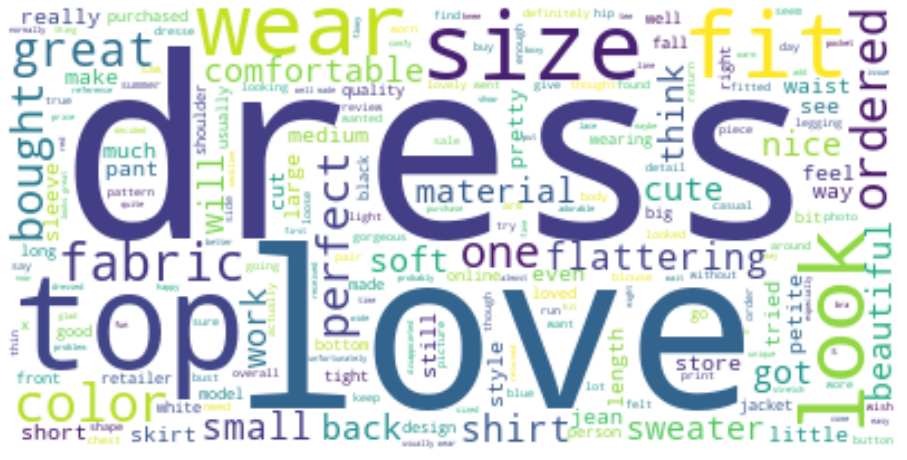

In [56]:
# Word Cloud

review_list = df_cloths['Review Text'].values.astype(str).tolist()
review_long_string = ','.join(review_list)

plt.figure(figsize=(16,12))
wordcloud = WordCloud(
                    background_color="white", 
                    max_words=800, 
                    contour_width=3, 
                    contour_color='steelblue'
                    )
wordcloud.generate(review_long_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **2. Text Data Preprocessing**

In [57]:
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stopwords_list = stopwords.words('english')

In [58]:
def lemmatization(lemmatizer,sentence):
    lem = [lemmatizer.lemmatize(k) for k in sentence]
    return [k for k in lem if k]

def remove_stop_words(stopwords_list,sentence):
    return [k for k in sentence if k not in stopwords_list]

def preprocess_one(tweet):
    tweet = tweet.lower()
    remove_punc = tokenizer.tokenize(tweet) # Remove puntuations
    remove_num = [re.sub('[0-9]', '', i) for i in remove_punc] # Remove Numbers
    remove_num = [i for i in remove_num if len(i)>0] # Remove empty strings
    lemmatized = lemmatization(lemmatizer,remove_num) # Word Lemmatization
    remove_stop = remove_stop_words(stopwords_list,lemmatized) # remove stop words
    updated_tweet = ' '.join(remove_stop)
    return updated_tweet

def preprocess(df_cloths):
    df_cloths['Preprocessed Review Text'] = df_cloths['Review Text'].apply(preprocess_one)
    return df_cloths

In [59]:
# LOAD CSV FILE

reviews = df_cloths['Review Text'].values 
sentiment = df_cloths['sentiment'].values

In [60]:
# PREPROCESS SAMPLE REVIEW 

sample_review = reviews[np.random.choice(len(reviews))]
preprocessed_sample_review = preprocess_one(sample_review)

print("*************************************************************** SAMPLE REVIEW *****************************************************************************")
print(sample_review)
print("\n***************************************************** SAMPLE REVIEW AFTER PREPROCESSING *****************************************************************")
print(preprocessed_sample_review)

*************************************************************** SAMPLE REVIEW *****************************************************************************
Not your classic sweatshirt. can be worn with black, grey, mauve

***************************************************** SAMPLE REVIEW AFTER PREPROCESSING *****************************************************************
classic sweatshirt worn black grey mauve


In [61]:
df_cloths = preprocess(df_cloths)
df_cloths

,Review Text,sentiment,Preprocessed Review Text
0,Absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,1,love dress sooo pretty happened find store gla...
2,I had such high hopes for this dress and reall...,0,high hope dress really wanted work initially o...
3,"I love, love, love this jumpsuit. it's fun, fl...",1,love love love jumpsuit fun flirty fabulous ev...
4,This shirt is very flattering to all due to th...,1,shirt flattering due adjustable front tie perf...
...,...,...,...
23481,I was very happy to snag this dress at such a ...,1,wa happy snag dress great price easy slip ha f...
23482,"It reminds me of maternity clothes. soft, stre...",1,reminds maternity clothes soft stretchy shiny ...
23483,"This fit well, but the top was very see throug...",0,fit well top wa see never would worked glad wa...
23484,I bought this dress for a wedding i have this ...,1,bought dress wedding summer cute unfortunately...


# **3. FEATURE EXTRACTION & CLASSIFICATION - METHOD 1**

In [15]:
corpus = df_cloths['Preprocessed Review Text'].values.astype(str).tolist()

TFIDFvectorizer = TfidfVectorizer()
X = TFIDFvectorizer.fit_transform(corpus)
Y = df_cloths['sentiment'].values

In [16]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [17]:
def fit_classifier(RFclassifier):

    RFclassifier.fit(Xtrain, Ytrain)

    Ptrain = RFclassifier.predict(Xtrain)
    Ptest = RFclassifier.predict(Xtest)

    train_accuracy = accuracy_score(Ytrain, Ptrain)
    test_accuracy = accuracy_score(Ytest, Ptest)

    return train_accuracy, test_accuracy

In [18]:
from sklearn.ensemble import RandomForestClassifier

RFclassifier = RandomForestClassifier(
                                max_depth=20, 
                                random_state=0,
                                class_weight=class_weights
                                )

train_accuracy, test_accuracy = fit_classifier(RFclassifier)

print("\n*********** RANDOM FOREST CLASSIFIER ***********")
print("\n    TRAIN ACCURACY: ", train_accuracy)
print("     TEST ACCURACY: ", test_accuracy)


*********** RANDOM FOREST CLASSIFIER ***********

    TRAIN ACCURACY:  0.9344081272084805
     TEST ACCURACY:  0.8597924486641643


In [19]:
from sklearn.svm import SVC

SVMclasifier = SVC(decision_function_shape='ovo')
train_accuracy, test_accuracy = fit_classifier(SVMclasifier)

print("\n*********** SVM CLASSIFIER ***********")
print("\n    TRAIN ACCURACY: ", train_accuracy)
print("     TEST ACCURACY: ", test_accuracy)


*********** SVM CLASSIFIER ***********

    TRAIN ACCURACY:  0.9776943462897526
     TEST ACCURACY:  0.8814307794215058


# **4. FEATURE EXTRACTION & CLASSIFICATION - METHOD 2**

In [20]:
corpus = df_cloths['Preprocessed Review Text'].values.astype(str).tolist()

COUNTERvectorizer = CountVectorizer()
X = COUNTERvectorizer.fit_transform(corpus)
Y = df_cloths['sentiment'].values

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
XGBOOSTclassifier = GradientBoostingClassifier(
                                            n_estimators=100,
                                            max_depth=20, 
                                            random_state=0
                                            )
train_accuracy, test_accuracy = fit_classifier(XGBOOSTclassifier)

print("\n*********** XGBOOSTclassifier CLASSIFIER ***********")
print("\n    TRAIN ACCURACY: ", train_accuracy)
print("     TEST ACCURACY: ", test_accuracy)


*********** XGBOOSTclassifier CLASSIFIER ***********

    TRAIN ACCURACY:  0.999392667844523
     TEST ACCURACY:  0.8580260543166262


In [22]:
from sklearn.tree import DecisionTreeClassifier
DTclassifier = DecisionTreeClassifier(
                                max_depth=20,
                                random_state=0
                                )
train_accuracy, test_accuracy = fit_classifier(DTclassifier)

print("\n*********** Naive Bayes CLASSIFIER ***********")
print("\n    TRAIN ACCURACY: ", train_accuracy)
print("     TEST ACCURACY: ", test_accuracy)


*********** Naive Bayes CLASSIFIER ***********

    TRAIN ACCURACY:  0.9318131625441696
     TEST ACCURACY:  0.8238021638330757


# **MODEL INFERENCE**

In [23]:
FEATURE_EXTRCATOR = TFIDFvectorizer
CLASSIFIER = XGBOOSTclassifier

In [28]:
review = "Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite."
preprocessed_review = preprocess_one(review)

review_vector = FEATURE_EXTRCATOR.transform([preprocessed_review])
review_sentiment = CLASSIFIER.predict(review_vector).squeeze().astype(int)
review_sentiment

array(1)